In [26]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [56]:
print(np.__version__)

1.26.4


In [27]:
colunas = ['Q092', 'C006', 'C00703', 'D00901', 'C009','C011','M01401','M01501', 'M01601', 'M01901', 
           'N001', 'N00101', 'N010','N011','N012', 'N013', 'N014', 'N015', 'N016','N017','N018','P027',
           'P034','P050','V00201','V00203','H001', 'V02802', 'Q120', 'VDF002', 'P018', 'P02002', 
           'P02602', 'P04502', 'J007'] # Adicionei J007 - 1, 3, 11, 14, 17, 18, 33


In [28]:
base = pd.read_csv('dados/pns2019.csv', delimiter=",", encoding='latin1', usecols=colunas)

In [29]:
col = base.pop('Q092')
base.insert(len(base.columns), 'Q092', col)

In [30]:
base.dropna(subset=['Q092'],inplace=True) # Deleta linhas em que a classe é nula
base = base.drop_duplicates() # Deleta linhas duplicadas

In [31]:
def mapear_cor(x):
    if x == 1:
        return 1 # Branco
    elif x == 2:
        return 2 # Preto + pardo
    elif  x == 4:
        return 2
    else:
        return 3 # Outros - Amarelo, indígena, ignorado (poucas instâncias)

# Aplicar a função de mapeamento à coluna
base['C009'] = base['C009'].apply(mapear_cor)

In [32]:
# Calcular o percentil 95 (por exemplo, para apagar salários no top 5%)
percentil_95 = base['VDF002'].quantile(0.95) # Valor decidido com base no gráfico da frequência de VDF002

base['VDF002'] = base['VDF002'].apply(lambda x: None if x > percentil_95 else x) 

In [33]:
# Normalização dos dados

from sklearn.preprocessing import MinMaxScaler

# Inicializar o scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar e transformar os dados de treinamento
base = scaler.fit_transform(base)

In [34]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

# Imputar os dados ausentes no conjunto de treino
base = imputer.fit_transform(base)

In [35]:
y = base[:, -1]  
X = base[:, :-1]
X.shape

(90835, 34)

In [36]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(random_state=42)
X, y= undersample.fit_resample(X, y)

Kmeans

In [37]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from kneed import KneeLocator #para mostrar o número de grupos ideal do agrupamento
from sklearn.cluster import KMeans #Importando a função Kmeans
from sklearn.metrics import silhouette_score

In [38]:
Entrada = X[:, [1, 3, 11, 14, 17, 18, 33]]

In [39]:
# Determinando a Silhouette para número máximo de cluster estimado (Raiz(instâncias/2)
limit = int((Entrada.shape[0]//2)**0.5)
for k in range(2, 5):
    model = KMeans(n_clusters=k)
    model.fit(Entrada)
    pred = model.predict(Entrada)
    score = silhouette_score(Entrada, pred)
    print('Silhouette Score k = {}: {:<.3f}'.format(k, score))

Silhouette Score k = 2: 0.348
Silhouette Score k = 3: 0.370
Silhouette Score k = 4: 0.365


In [40]:
wcss = []
for i in range(2, 11):
  #print(i)
  kmeans = KMeans(n_clusters=i, random_state=10)
  kmeans.fit(Entrada)
  wcss.append(kmeans.inertia_)

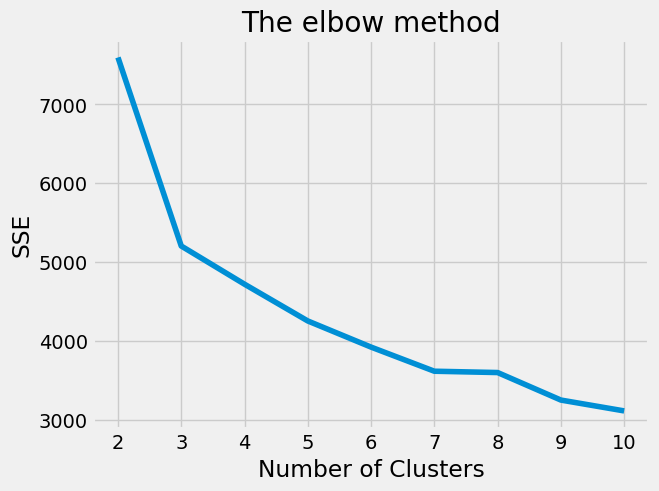

In [41]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), wcss)
plt.xticks(range(2, 11))
plt.title('The elbow method')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [42]:
kl = KneeLocator(range(2, 11), wcss, curve="convex", direction="decreasing")
kl.elbow

3

In [43]:

kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
saida_kmeans = kmeans.fit_predict(Entrada)

In [44]:
from sklearn.decomposition import PCA

# Reduzindo os dados para 2D com PCA
pca = PCA(n_components=2)
array_2d = pca.fit_transform(Entrada)

# Os coeficientes dos componentes principais
components = pd.DataFrame(pca.components_, columns=["Var"+str(i) for i in range(Entrada.shape[1])])

# Exibir os coeficientes dos Componentes Principais
print(components)

       Var0      Var1      Var2      Var3      Var4      Var5      Var6
0 -0.005707  0.165600  0.234862  0.567224  0.468695  0.610395 -0.058166
1  0.019861  0.981914 -0.051884 -0.089415 -0.090622 -0.101144 -0.079506


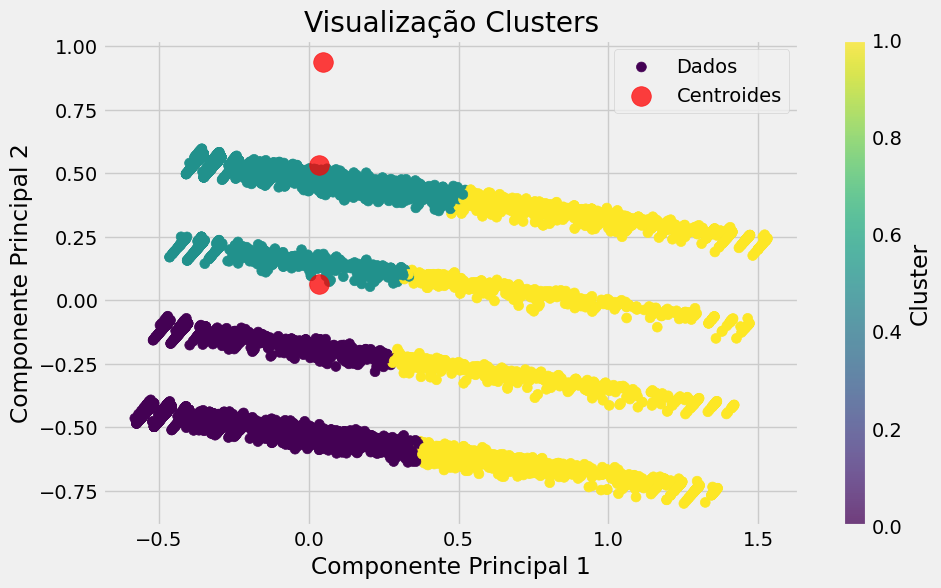

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(array_2d[:, 0], array_2d[:, 1], c=saida_kmeans, cmap='viridis', s=50, label="Dados")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, label="Centroides")
plt.title("Visualização Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


In [46]:
incorrect = (saida_kmeans != y)

In [47]:
np.unique(incorrect, return_counts=True)

(array([False,  True]), array([7225, 9437]))

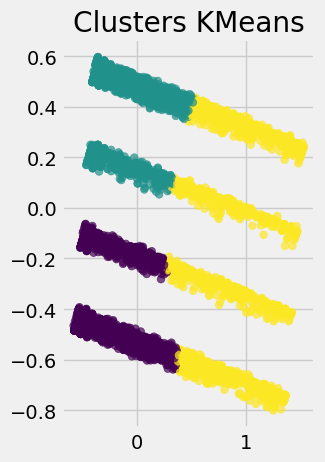

In [55]:
plt.subplot(1, 2, 1)
plt.scatter(array_2d[:, 0], array_2d[:, 1], c=saida_kmeans, cmap='viridis', s=30, alpha=0.7)
plt.title('Clusters KMeans')
plt.show()

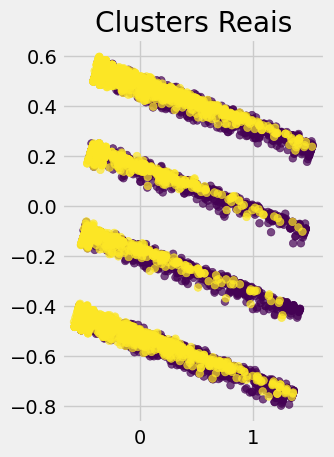

In [54]:
# Subplot 2: Rótulos reais
plt.subplot(1, 2, 2)
plt.scatter(array_2d[:, 0], array_2d[:, 1], c=y, cmap='viridis', s=30, alpha=0.7)
plt.title('Clusters Reais')
plt.tight_layout()
plt.show()

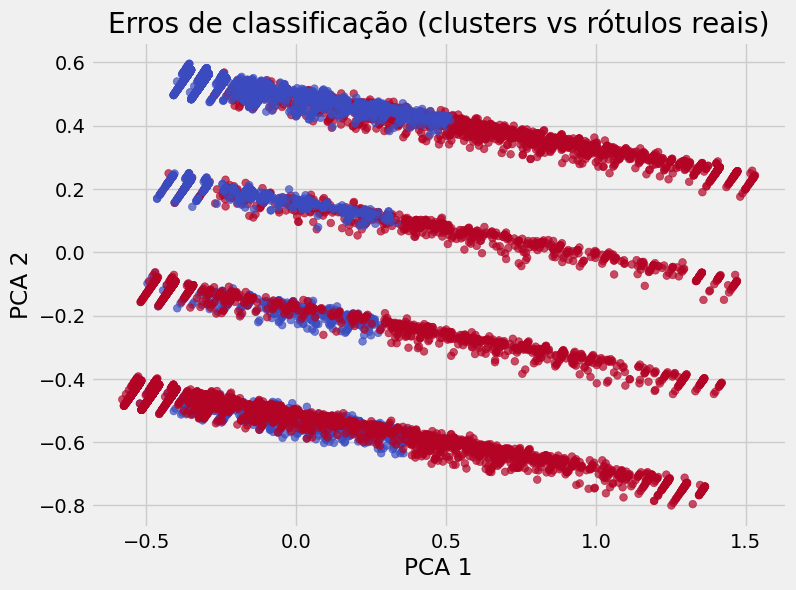

In [50]:
errors = saida_kmeans != y
plt.figure(figsize=(8, 6))
plt.scatter(array_2d[:, 0], array_2d[:, 1], c=errors, cmap='coolwarm', s=30, alpha=0.7)
plt.title('Erros de classificação (clusters vs rótulos reais)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()